In [1]:
from google.colab import drive
drive.mount('cnontent/')

Mounted at cnontent/


In [ ]:
!pip install -q wandb

In [2]:
import tqdm
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import wandb
# from wandb.keras import WandbCallback
import os
import random
%matplotlib inline

In [3]:
cd /content/cnontent/MyDrive/SSU/nural_nework/project

/content/cnontent/MyDrive/SSU/nural_nework/project


In [4]:
ls

a.png                     mobile2
augmented_emnist.csv      Mobile_ELU_SGD_1000_120_005.h5
balanced_train_label.npy  Mobile_Leacky_SGD_800_100_05.h5
balanced_train.npy        Mobile_Leacky_SGD_800_100_05.h5_1/
balanced_val_label.npy    Mobile_ReLU_SGD_800_05.h5
balanced_val.npy          my_lenet5_emnist_model_20220515.h5
checkpoint                our_handmade_dataset.csv
emnist-byclass-test.csv   res_res_ckp/
emnist-byclass-train.csv  test_dataset_학점살려조.csv
images/                   wandb/


In [5]:
def convert_data_csv_to_numpy(data, sorting = False): # pandas 통해 읽은 csv data numpy 형태로 변경
  if sorting == True:
    data = data.sort_values(by=[0], axis=0)

  label = np.array(data[0]) # csv file 에서 0번째 colum은 index임
  only_data = np.array(data.drop([0], axis = 1)).reshape((-1, 28, 28, 1)) # csv file에서 0번 째 colum 탈락 -> data만 남게 됨
  # only_data = tf.convert_to_tensor(only_data, dtype=tf.float32)
  return only_data, label

In [6]:
def balanced_data(data, label, border, n_train=1000, val_rate = 0.2):
  i, start=0,0
  d_train = l_train = d_val = l_val= None
  n_data_per_class = n_train
  n_val_per_class = int(n_data_per_class*val_rate)


  for idx, class_end in enumerate(border):
    if i ==0:
      val_end = n_data_per_class+n_val_per_class

      d_train = data[:n_data_per_class].copy()
      l_train = label[:n_data_per_class].copy()

      d_val = data[n_data_per_class:val_end].copy()
      l_val = label[n_data_per_class:val_end].copy()

      i+=1
    else:
      train_end = start+n_data_per_class
      val_end = train_end+n_val_per_class

      now_d_data = data[start:train_end].copy()
      now_l_train = label[start:train_end].copy()
      d_train = np.concatenate((d_train, now_d_data))
      l_train = np.concatenate((l_train, now_l_train))

      now_d_val = data[train_end:val_end].copy()
      now_l_val = label[train_end:val_end].copy()
      d_val = np.concatenate((d_val, now_d_val))
      l_val = np.concatenate((l_val, now_l_val))
    start += class_end
  return (d_train, l_train, d_val, l_val)

In [7]:
train_csv, test_csv = [], []
train_csv = pd.read_csv("./emnist-byclass-train.csv", header=None)

In [8]:
# train, train_label = convert_data_csv_to_numpy(train_csv, sorting = True)
train, train_label = convert_data_csv_to_numpy(train_csv, sorting = False)
train_csv = []

In [9]:
train_data = tf.convert_to_tensor(train, dtype=tf.float32)

In [10]:
boundary = int(train_data.shape[0]*0.8)

final_train = train_data[:boundary]
final_train_label = train_label[:boundary]

final_val = train_data[boundary:]
final_val_label = train_label[boundary:]

In [11]:
print(final_train.shape)
print(final_train_label.shape)
print(final_val.shape)
print(final_val_label.shape)

(558345, 28, 28, 1)
(558345,)
(139587, 28, 28, 1)
(139587,)


In [ ]:
# train_data = np.load('./balanced_train.npy')
# train_label = np.load('./balanced_train_label.npy')
# val_data = np.load('./balanced_val.npy')
# val_label = np.load('./balanced_val_label.npy')

In [ ]:
# print(train_data.shape)
# print(train_label.shape)
# print(val_data.shape)
# print(val_label.shape)

(62000, 28, 28, 1)
(62000,)
(12400, 28, 28, 1)
(12400,)


In [12]:
class ResnetBlock(keras.models.Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = keras.layers.Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = keras.layers.BatchNormalization()
        self.conv_2 = keras.layers.Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = keras.layers.BatchNormalization()
        self.merge = keras.layers.Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = keras.layers.Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = keras.layers.BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

In [ ]:
for i, a in enumerate([3, 5, 6]):
  print(a)

3
5
6


In [13]:
class Res_5x5_v4(keras.models.Model):

    def __init__(self, num_classes, config_list, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)

        self.input_ch, self.activation, self.feature_layer_depth, self.num_layer_nueron, self.upper_layer_nueron, self.lower_layer_nueron = config_list


        self.Global_Average_Pool_Layer = keras.layers.GlobalAveragePooling2D()
        self.Flatten_Layer = keras.layers.Flatten()

        self.Feature_Detection_Layer = self.feature_detection_layer()

        self.Number_Layer = self.number_layer()
        self.Upper_Letter_Layer = self.upper_letter_layer()
        self.Lower_Letter_Layer = self.lower_letter_layer()


        self.Prediction_Layer = keras.layers.Dense(num_classes, activation="softmax")

    def feature_detection_layer(self):
      feature_dec_layer = keras.models.Sequential()
      feature_dec_layer.add(keras.layers.BatchNormalization())
      feature_dec_layer.add(keras.layers.Conv2D(self.input_ch, (5, 5), strides=1, padding="same", kernel_initializer="he_normal"))
      feature_dec_layer.add(keras.layers.BatchNormalization())
      feature_dec_layer.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=1, padding="same"))
      feature_dec_layer.add(ResnetBlock(self.input_ch))
      feature_dec_layer.add(ResnetBlock(self.input_ch))
      
      for i in range(self.feature_layer_depth-1):
        feature_dec_layer.add(ResnetBlock(self.input_ch*(2*(i+1)), down_sample=True))
        feature_dec_layer.add(ResnetBlock(self.input_ch*(2*(i+1))))

      feature_dec_layer.add(self.Global_Average_Pool_Layer)
      feature_dec_layer.add(self.Flatten_Layer)


      return feature_dec_layer

    def number_layer(self):
      num_layer = keras.models.Sequential()
      for i, num_nueron in enumerate(self.num_layer_nueron):
        num_layer.add(tf.keras.layers.Dense(num_nueron))
        num_layer.add(self.select_activation(self.activation))
        num_layer.add(keras.layers.BatchNormalization())
    
      num_layer.add(tf.keras.layers.Dense(10, activation = None))

      return num_layer

    def upper_letter_layer(self):
      upper_layer = keras.models.Sequential()
      for i, num_nueron in enumerate(self.upper_layer_nueron):
        upper_layer.add(tf.keras.layers.Dense(num_nueron))
        upper_layer.add(self.select_activation(self.activation))
        upper_layer.add(keras.layers.BatchNormalization())

      upper_layer.add(tf.keras.layers.Dense(26, activation = None))
      return upper_layer

    def lower_letter_layer(self):
      lower_layer = keras.models.Sequential()

      for i, num_nueron in enumerate(self.lower_layer_nueron):
        lower_layer.add(tf.keras.layers.Dense(num_nueron))
        lower_layer.add(self.select_activation(self.activation))
        lower_layer.add(keras.layers.BatchNormalization())

      lower_layer.add(tf.keras.layers.Dense(26, activation = None))
      return lower_layer

    def select_activation(self, function):
      if function == 'relu':
        activation = keras.layers.ReLU()
      elif function == 'prelu':
        activation = keras.layers.PReLU()
      elif function == 'leacky_relu':
        activation = keras.layers.LeakyReLU()
      elif function == 'elu':
        activation = keras.layers.ELU()
      else:
        activation = keras.layers.ReLU()
      return activation

In [14]:
def select_model(config_list):
  model_class = Res_5x5_v4(64, config_list)

  input = keras.layers.Input(shape=(28, 28, 1))

  feature_out = model_class.Feature_Detection_Layer(input)

  num_out = model_class.Number_Layer(feature_out)
  upper_out = model_class.Upper_Letter_Layer(feature_out)
  lower_out = model_class.Lower_Letter_Layer(feature_out)

  final_out = keras.layers.concatenate([num_out, upper_out, lower_out])
  result = tf.nn.softmax(final_out)

  model = keras.models.Model(inputs=[input], outputs=[result])
  return model

In [15]:
test = [64, 'relu', 2, [100, 50], [200, 100 , 50], [100, 50]]

In [16]:
test_model = select_model(test)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


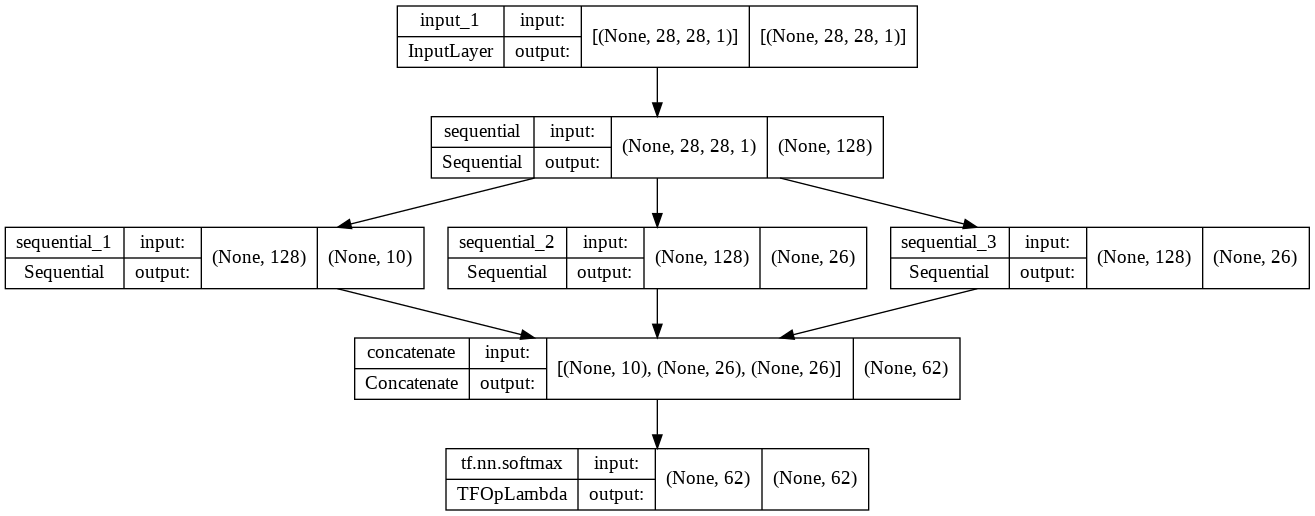

In [17]:
keras.utils.plot_model(test_model, "a.png", show_shapes=True)

In [ ]:
test_model.layers[1].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 28, 28, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 64)       0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  (None, 28, 28, 64)        74368     
                                                        

In [ ]:
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 128)          678148      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 10)           19060       ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 26)           53676       ['sequential[0][0]']             
                                                                                              

In [ ]:
test_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [ ]:
keras.layers.BatchNormalization()

In [18]:
def select_opt(opt_name, lr):
  if opt_name == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
  elif opt_name == 'rmsprop':
    optimizer = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9)
  elif opt_name == 'sgd':
    optimizer = keras.optimizers.SGD(learning_rate = lr)
  elif opt_name == 'momentum':
    optimizer = keras.optimizers.SGD(learning_rate = lr, momentum=0.9)
  elif opt_name == 'nesterov':
    optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
  elif opt_name == 'adagrad':
    optimizer = keras.optimizers.Adagrad(learning_rate=lr)
  elif opt_name == 'adamax':
    optimizer = keras.optimizers.Adamax(learning_rate=lr, beta_1=0.9, beta_2=0.999)
  elif opt_name == 'nadam':
    optimizer = keras.optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)

  return optimizer

In [30]:
def get_layer_nueron_list(channel, num_feature_layer ,num_layer, num_out_nueron):
  num_input = channel*num_feature_layer
  nueron_list = []
  interval = (num_input-num_out_nueron)//(num_layer+1)
  criterion = num_input
  for i in range(num_layer):
    criterion -= interval
    nueron_list.append(criterion)
  return nueron_list

In [41]:
test_csv = pd.read_csv("./emnist-byclass-test.csv", header=None)
hand_made_csv = pd.read_csv("./our_handmade_dataset.csv", header=None)

In [42]:
test_data, test_label = convert_data_csv_to_numpy(test_csv, sorting = False)
hand_data, hand_label = convert_data_csv_to_numpy(hand_made_csv, sorting = False)

In [38]:
# 32, 2, 2, 1, 2
model1_list = [32, 'relu', 2, get_layer_nueron_list(32, 2, 2, 10), get_layer_nueron_list(32, 2, 1, 16), get_layer_nueron_list(32, 2, 2, 16)] # 76.35%
# 16, 2, 2, 2, 3
model2_list = [16, 'relu', 2, get_layer_nueron_list(16, 2, 2, 10), get_layer_nueron_list(16, 2, 2, 16), get_layer_nueron_list(16, 2, 3, 16)] # 75.94%
# 32, 2, 1, 1, 2
model3_list = [32, 'elu', 2, get_layer_nueron_list(32, 2, 2, 10), get_layer_nueron_list(32, 2, 1, 16), get_layer_nueron_list(32, 2, 2, 16)] # 75.87%
# 64, 2, 3, 3, 2
model4_list = [64, 'relu', 2, get_layer_nueron_list(64, 2, 3, 10), get_layer_nueron_list(64, 2, 3, 16), get_layer_nueron_list(64, 2, 2, 16)] # 75.92

In [43]:
first_model = select_model(model1_list)
second_model = select_model(model2_list)
third_model = select_model(model3_list)
fourth_model = select_model(model4_list)

first_model.summary()
second_model.summary()
third_model.summary()
fourth_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_36 (Sequential)     (None, 64)           171140      ['input_10[0][0]']               
                                                                                                  
 sequential_37 (Sequential)     (None, 10)           4892        ['sequential_36[0][0]']          
                                                                                                  
 sequential_38 (Sequential)     (None, 26)           3826        ['sequential_36[0][0]']          
                                                                                            

In [46]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# model_checkpoint_cb = keras.callbacks.ModelCheckpoint("resres_2_1_2_1_0_200.h5", save_best_only=True)

learning_rate = 0.01
opt = select_opt('momentum', learning_rate)
print(opt)
first_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
first_history = first_model.fit(final_train, final_train_label, epochs=50, validation_data=(final_val, final_val_label), callbacks=[early_stopping_cb])

Epoch 1/50
17449/17449 [==============================] - 234s 13ms/step - loss: 0.5234 - accuracy: 0.8245 - val_loss: 0.4343 - val_accuracy: 0.8478
Epoch 2/50
17449/17449 [==============================] - 234s 13ms/step - loss: 0.4091 - accuracy: 0.8529 - val_loss: 0.4004 - val_accuracy: 0.8547
Epoch 3/50
17449/17449 [==============================] - 233s 13ms/step - loss: 0.3871 - accuracy: 0.8593 - val_loss: 0.3834 - val_accuracy: 0.8535
Epoch 4/50
17449/17449 [==============================] - 232s 13ms/step - loss: 0.3747 - accuracy: 0.8628 - val_loss: 0.3733 - val_accuracy: 0.8611
Epoch 5/50
17449/17449 [==============================] - 231s 13ms/step - loss: 0.3657 - accuracy: 0.8652 - val_loss: 0.3565 - val_accuracy: 0.8689
Epoch 6/50
17449/17449 [==============================] - 230s 13ms/step - loss: 0.3592 - accuracy: 0.8671 - val_loss: 0.3779 - val_accuracy: 0.8582
Epoch 7/50
17449/17449 [==============================] - 231s 13ms/step - loss: 0.3539 - accuracy: 0.8687

In [47]:
first_model.evaluate(test_data, test_label)

3636/3636 [==============================] - 20s 5ms/step - loss: 0.3357 - accuracy: 0.8750


[0.3356820046901703, 0.8749688267707825]

In [44]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# model_checkpoint_cb = keras.callbacks.ModelCheckpoint("resres_2_1_2_1_0_200.h5", save_best_only=True)

learning_rate = 0.05
opt = select_opt('adagrad', learning_rate)
print(opt)
second_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
second_history = second_model.fit(final_train, final_train_label, epochs=50, validation_data=(final_val, final_val_label), callbacks=[early_stopping_cb])

Epoch 1/50
17449/17449 [==============================] - 244s 14ms/step - loss: 0.5826 - accuracy: 0.8108 - val_loss: 0.4858 - val_accuracy: 0.8176
Epoch 2/50
17449/17449 [==============================] - 236s 14ms/step - loss: 0.4410 - accuracy: 0.8451 - val_loss: 0.4516 - val_accuracy: 0.8438
Epoch 3/50
17449/17449 [==============================] - 238s 14ms/step - loss: 0.4169 - accuracy: 0.8517 - val_loss: 0.3857 - val_accuracy: 0.8610
Epoch 4/50
17449/17449 [==============================] - 235s 13ms/step - loss: 0.4030 - accuracy: 0.8551 - val_loss: 0.3843 - val_accuracy: 0.8605
Epoch 5/50
17449/17449 [==============================] - 227s 13ms/step - loss: 0.3941 - accuracy: 0.8577 - val_loss: 0.3789 - val_accuracy: 0.8624
Epoch 6/50
17449/17449 [==============================] - 227s 13ms/step - loss: 0.3876 - accuracy: 0.8599 - val_loss: 0.3750 - val_accuracy: 0.8635
Epoch 7/50
17449/17449 [==============================] - 228s 13ms/step - loss: 0.3816 - accuracy: 0.8618

In [45]:
second_model.evaluate(test_data, test_label)

3636/3636 [==============================] - 19s 5ms/step - loss: 0.3547 - accuracy: 0.8709


[0.35470741987228394, 0.8708509802818298]

In [48]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# model_checkpoint_cb = keras.callbacks.ModelCheckpoint("resres_2_1_2_1_0_200.h5", save_best_only=True)

learning_rate = 0.05
opt = select_opt('nadam', learning_rate)
print(opt)
third_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
third_history = third_model.fit(final_train, final_train_label, epochs=50, validation_data=(final_val, final_val_label), callbacks=[early_stopping_cb])

Epoch 1/50
17449/17449 [==============================] - 381s 22ms/step - loss: 0.6791 - accuracy: 0.7893 - val_loss: 0.6431 - val_accuracy: 0.8081
Epoch 2/50
17449/17449 [==============================] - 371s 21ms/step - loss: 0.5554 - accuracy: 0.8226 - val_loss: 1.3042 - val_accuracy: 0.8163
Epoch 3/50
17449/17449 [==============================] - 370s 21ms/step - loss: 0.5245 - accuracy: 0.8305 - val_loss: 0.4942 - val_accuracy: 0.8308
Epoch 4/50
17449/17449 [==============================] - 373s 21ms/step - loss: 0.5073 - accuracy: 0.8354 - val_loss: 0.5663 - val_accuracy: 0.8362
Epoch 5/50
17449/17449 [==============================] - 371s 21ms/step - loss: 0.4938 - accuracy: 0.8390 - val_loss: 0.6087 - val_accuracy: 0.8138
Epoch 6/50
17449/17449 [==============================] - 373s 21ms/step - loss: 0.4859 - accuracy: 0.8415 - val_loss: 0.6319 - val_accuracy: 0.8208
Epoch 7/50
17449/17449 [==============================] - 378s 22ms/step - loss: 0.4777 - accuracy: 0.8432

In [49]:
third_model.evaluate(test_data, test_label)

3636/3636 [==============================] - 20s 5ms/step - loss: 0.4465 - accuracy: 0.8442


[0.4465060830116272, 0.8442440629005432]

In [50]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# model_checkpoint_cb = keras.callbacks.ModelCheckpoint("resres_2_1_2_1_0_200.h5", save_best_only=True)

learning_rate = 0.005
opt = select_opt('nadam', learning_rate)
print(opt)
fourth_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
fourth_history = fourth_model.fit(final_train, final_train_label, epochs=50, validation_data=(final_val, final_val_label), callbacks=[early_stopping_cb])

Epoch 1/50
17449/17449 [==============================] - 507s 29ms/step - loss: 0.5306 - accuracy: 0.8199 - val_loss: 0.5364 - val_accuracy: 0.8128
Epoch 2/50
17449/17449 [==============================] - 506s 29ms/step - loss: 0.4165 - accuracy: 0.8510 - val_loss: 0.4229 - val_accuracy: 0.8483
Epoch 3/50
17449/17449 [==============================] - 521s 30ms/step - loss: 0.3931 - accuracy: 0.8577 - val_loss: 0.4042 - val_accuracy: 0.8564
Epoch 4/50
17449/17449 [==============================] - 509s 29ms/step - loss: 0.3787 - accuracy: 0.8619 - val_loss: 0.3842 - val_accuracy: 0.8613
Epoch 5/50
17449/17449 [==============================] - 498s 29ms/step - loss: 0.3678 - accuracy: 0.8653 - val_loss: 0.3904 - val_accuracy: 0.8634
Epoch 6/50
17449/17449 [==============================] - 497s 29ms/step - loss: 0.3597 - accuracy: 0.8680 - val_loss: 0.3715 - val_accuracy: 0.8643
Epoch 7/50
17449/17449 [==============================] - 495s 28ms/step - loss: 0.3538 - accuracy: 0.8695

In [51]:
fourth_model.evaluate(test_data, test_label)

3636/3636 [==============================] - 29s 8ms/step - loss: 0.3396 - accuracy: 0.8726


[0.3395899534225464, 0.8726133108139038]

In [ ]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        print(f'''
              epcoh : {epoch}
              loss {logs['loss']}
              accuracy {logs['accuracy']}
              val_loss {logs['val_loss']}
              val_accuracy {logs['val_accuracy']}
              ''')
        wandb.log({'epochs': epoch,
            'loss': logs['loss'],
            'acc': logs['accuracy'], 
            'val_loss': logs['val_loss'],
            'val_acc': logs['val_accuracy']})
        

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [33]:
a = get_layer_nueron_list(32, 3, 2, 26)
print(a)

[73, 50]


In [ ]:
def sweep_train(config_defaults=None):
    # Set default values
    test = ['relu', 2, [100, 50], [200, 100 , 50], [100, 50]]

    config_defaults = {
      'channel' : 32,
      'batch_size': 64,
      'activation': 'relu',
      'optimizer' : 'adam',
      'learning_rate' : 0.01,
      'feature_layer_depth' : 2,
      'num_layer_depth' : 2,
      'upper_layer_depth' : 2,
      'lower_layer_depth' : 2,
    }
    # Initialize wandb with a sample project name
    wandb.init(config=config_defaults)  # this gets over-written in the Sweep

    last_neuron_perlayer = [10, 26, 26]
    num_dense_per_layer = [wandb.config.num_layer_depth, wandb.config.upper_layer_depth, wandb.config.lower_layer_depth]
    num_flatten_layer = wandb.config.channel * wandb.config.feature_layer_depth
    nueron_list = []

    for last_nueron, num_dense in zip(last_neuron_perlayer, num_dense_per_layer):
      now_layer_nueron = []
      boundary = (num_flatten_layer - last_nueron)//(num_dense+1)
      now_nueron = num_flatten_layer
      for i in range(num_dense):
        now_nueron -= boundary
        now_layer_nueron.append(now_nueron)
      nueron_list.append(now_layer_nueron)

    print(nueron_list)

    # initialize model
    config_list = [
                    wandb.config.channel, wandb.config.activation, wandb.config.feature_layer_depth, 
                    nueron_list[0], nueron_list[1], nueron_list[2]
                   ]
    model = select_model(config_list)
    
    print(model.summary())

    # Instantiate an optimizer to train the model.
    optimizer = select_opt(wandb.config.optimizer, wandb.config.learning_rate)


    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                steps_per_execution=1000,
                metrics=["accuracy"])
    hist = model.fit(train_data, train_label, epochs=50, validation_data=(val_data, val_label), callbacks=[LossAndErrorPrintingCallback(), early_stopping_cb])

In [ ]:
sweep_config = {
  'method': 'random', 
  'parameters': {
      
      'channel': {
          'values' : [16, 32, 64]
      },
      'optimizer': {
          'values' : ['adam', 'rmsprop', 'sgd', 'momentum', 'nesterov', 'adagrad', 'adamax', 'nadam']
      },
      'learning_rate':{
          'values' : [0.1, 0.05, 0.01, 0.005]
      },
      'feature_layer_depth' : {
          'values' : [1, 2, 3]
      },
      'num_layer_depth' : {
          'values' : [1, 2, 3]
      },
      'upper_layer_depth' : {
          'values' : [1, 2, 3]
      },
      'lower_layer_depth' : {
          'values' : [1, 2, 3]
      },
      'activation' : {
          'values' : ['relu', 'leacky_relu', 'elu']
      }
  }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="res_dense_2")

Create sweep with ID: lsd02qzy
Sweep URL: https://wandb.ai/chanin-eom/res_dense_2/sweeps/lsd02qzy


In [ ]:
wandb.agent(sweep_id, function=sweep_train, count=50)